In [39]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have paths to your TFRecord files
train_tfrecord_files = ['./data/FRC Charged Up Game Pieces.v7i.tfrecord/train/cubes-cones.tfrecord']
valid_tfrecord_files = ['./data/FRC Charged Up Game Pieces.v7i.tfrecord/valid/cubes-cones.tfrecord']
test_tfrecord_files  = ['./data/FRC Charged Up Game Pieces.v7i.tfrecord/test/cubes-cones.tfrecord']

batch_size = 32

# Define your preprocessing pipeline
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

# Load and preprocess the data
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        # Add more features as needed
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    return preprocess(image), example['image/class/label']

# Load TFRecord datasets
train_set_raw = tf.data.TFRecordDataset(train_tfrecord_files)
train_set = train_set_raw.map(parse_tfrecord_fn).shuffle(1000, seed=42).batch(batch_size).prefetch(1)

valid_set_raw = tf.data.TFRecordDataset(valid_tfrecord_files)
valid_set = valid_set_raw.map(parse_tfrecord_fn).batch(batch_size)

test_set_raw = tf.data.TFRecordDataset(test_tfrecord_files)
test_set = test_set_raw.map(parse_tfrecord_fn).batch(batch_size)


c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D

# Define the YOLO-like model
def build_object_detection_model(num_classes, num_anchors):
    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Feature extraction layers
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    # ... Add more convolutional layers as needed
    
    # Global average pooling and classification branch
    x_cls = GlobalAveragePooling2D()(x)
    outputs_cls = Dense(num_classes, activation='softmax', name='classification')(x_cls)
    
    # Bounding box regression branch
    x_bbox = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x_bbox = GlobalAveragePooling2D()(x_bbox)
    outputs_bbox = Dense(num_anchors * 4, activation='linear', name='bounding_box')(x_bbox)
    
    model = tf.keras.Model(inputs=inputs, outputs=[outputs_cls, outputs_bbox])
    return model

# Number of classes (categories) in your dataset
num_classes = 1

# Number of anchor boxes for bounding box regression (adjust based on your dataset)
num_anchors = 9

# Build the model
model = build_object_detection_model(num_classes, num_anchors)

# Display model summary
model.summary()

# Compile the model
classification_loss_fn = tf.keras.losses.CategoricalCrossentropy()
regression_loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer='adam', loss={'classification': classification_loss_fn, 'bounding_box': regression_loss_fn})

# Train the model
model.fit(train_set, epochs=10)  # Adjust the number of epochs as needed


In [ ]:
import tensorflow as tf

# Path to the TFRecord file
tfrecord_path = './data/FRC Charged Up Game Pieces.v7i.tfrecord/train/cubes-cones.tfrecord'

# Load the TFRecord dataset
raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

# Iterate through a few examples to inspect the feature names and data types
for raw_record in raw_dataset.take(1):  # You can adjust the number of examples to inspect
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    print("Features in the example:")
    for feature_name in example.features.feature.keys():
        feature = example.features.feature[feature_name]
        print(f"Feature Name: {feature_name}")
        print(f"Feature Type: {feature.WhichOneof('kind')}")
        print()

    print("=" * 30)


In [131]:
import tensorflow as tf

# Define the feature description based on the discovered features
feature_description = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # Add more features as needed
}

# Parsing function to extract features
def parse_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode image bytes
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    
    # Extract other features
    width = example['image/width']
    height = example['image/height']
    xmin = example['image/object/bbox/xmin']
    ymin = example['image/object/bbox/ymin']
    xmax = example['image/object/bbox/xmax']
    ymax = example['image/object/bbox/ymax']
    label = example['image/object/class/label']
    text = example['image/object/class/text']
    # Extract and process bounding box coordinates and class labels

    # text_dense = tf.sparse.to_dense(text, default_value=b'')

    # print("Image Shape:", image.shape)
    # print("Image Width:", width.numpy())
    # print("Image Height:", height.numpy())
    # print("Image xmin:", xmin.values[0].numpy())
    # print("Image ymin:", ymin.values[0].numpy())
    # print("Image xmax:", xmax.values[0].numpy())
    # print("Image ymax:", ymax.values[0].numpy())
    # print("Image label:", label.values[0].numpy())
    # print("Image text:", text_dense[0].numpy().decode('utf-8'))

    return image, width, height, xmin, ymin, xmax, ymax, label, text

raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

# Apply the parsing function to each example
parsed_dataset = raw_dataset.map(parse_tfrecord)

# Iterate through the parsed dataset
for image, width, height, xmin, ymin, xmax, ymax, label, text  in parsed_dataset.take(1):
    text_dense = tf.sparse.to_dense(text, default_value=b'')

    # Process extracted features as needed
    print("Image Shape:", image.shape)
    print("Image Width:", width.numpy())
    print("Image Height:", height.numpy())
    print("Image xmin:", xmin.values[0].numpy())
    print("Image ymin:", ymin.values[0].numpy())
    print("Image xmax:", xmax.values[0].numpy())
    print("Image ymax:", ymax.values[0].numpy())
    print("Image label:", label.values[0].numpy())
    print("Image text:", text_dense[0].numpy().decode('utf-8'))
    # Print and process more features as needed


Image Shape: (416, 416, 3)
Image Width: 416
Image Height: 416
Image xmin: 0.2596154
Image ymin: 0.100961536
Image xmax: 0.8269231
Image ymax: 0.99038464
Image label: 2
Image text: cube


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

# Define the YOLO-like model
def build_object_detection_model(num_classes, num_anchors):
    input_shape = (416, 416, 3)  # Adjusted to match the shape of your parsed images
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Feature extraction layers
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    # ... Add more convolutional layers as needed
    
    # Global average pooling for classification branch
    x_cls = GlobalAveragePooling2D()(x)
    outputs_cls = Dense(num_classes, activation='softmax', name='classification')(x_cls)
    
    # Bounding box regression branch
    x_bbox = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x_bbox = GlobalAveragePooling2D()(x_bbox)
    outputs_bbox = Dense(num_anchors * 4, activation='linear', name='bounding_box')(x_bbox)
    
    model = tf.keras.Model(inputs=inputs, outputs=[outputs_cls, outputs_bbox])
    return model

# Number of classes (categories) in your dataset
num_classes = 3

# Number of anchor boxes for bounding box regression (adjust based on your dataset)
num_anchors = 9

# Build the model
model = build_object_detection_model(num_classes, num_anchors)

# Display model summary
model.summary()

# Compile the model
classification_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
regression_loss_fn = tf.keras.losses.MeanSquaredError()

def dense_regression_loss(y_true, y_pred):
    return regression_loss_fn(y_true, y_pred)

model.compile(optimizer='adam', loss={'classification': classification_loss_fn, 'bounding_box': dense_regression_loss})



# Preprocess the dataset and reshape images to match the input shape of the model
def preprocess_dataset(image, width, height, xmin, ymin, xmax, ymax, label, text):
    # Resize and normalize the image
    processed_image = tf.image.resize(image, (416, 416))
    processed_image = tf.keras.applications.xception.preprocess_input(processed_image)
    
    # Convert label to int64 and convert to categorical for classification
    # label = tf.cast(label, tf.int64)
    label = tf.sparse.to_dense(label)  # Convert SparseTensor to dense tensor
    label_one_hot = tf.one_hot(label, num_classes)
    
    # Convert sparse bounding box coordinates to dense tensors
    xmin_dense = tf.sparse.to_dense(xmin)
    ymin_dense = tf.sparse.to_dense(ymin)
    xmax_dense = tf.sparse.to_dense(xmax)
    ymax_dense = tf.sparse.to_dense(ymax)
    
    # Stack the bounding box target
    bbox_target = tf.stack([xmin_dense, ymin_dense, xmax_dense, ymax_dense], axis=-1)
    
    return processed_image, (label, bbox_target)

prepared_dataset = parsed_dataset.map(preprocess_dataset)

# Separate features and labels
def split_features_labels(image, label_bbox):
    return image, label_bbox[0], label_bbox[1]

prepared_dataset = prepared_dataset.map(preprocess_dataset)
def convert_labels(img, label_bbox):
    label, bbox_target = label_bbox
    label_categorical = tf.one_hot(label, num_classes)
    return img, (label_categorical, bbox_target)

prepared_dataset = prepared_dataset.map(convert_labels)
prepared_dataset = prepared_dataset.map(lambda img, label, bbox_target, width, height, xmin, ymin, xmax, ymax, text: preprocess_dataset(img, width, height, xmin, ymin, xmax, ymax, label, text))

# Specify the batch size
batch_size = 32  # You can adjust this value based on your available memory

# Batch the prepared dataset
batched_dataset = prepared_dataset.batch(batch_size)

# Train the model
num_epochs = 10
model.fit(batched_dataset, epochs=num_epochs)  # Adjust the number of epochs as needed


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[2]
[3]
[2]
[1]
[2]
[2]
[2]
[2]
[]
[2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3 2 2 2 1 1 1 1 1 1 2 2 1]
[2]


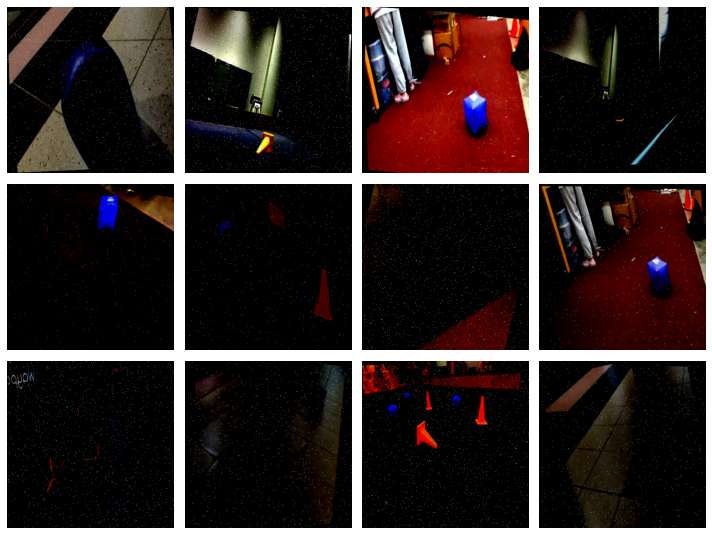

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot images and their labels
def plot_images(images, labels, class_names, num_images=12):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        print(labels[i])
        label = np.argmax(labels[i])  # Convert one-hot label to class index
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Extract class names
class_names = ["Cube", "Cone", "tipped", "none"]  # Replace with your actual class names

# Extract a few examples from the prepared dataset
example_images = []
example_labels = []

for image, (label, _) in prepared_dataset.take(12):
    example_images.append(image.numpy())
    example_labels.append(label.numpy())

# Plot the extracted examples
plot_images(example_images, example_labels, class_names)


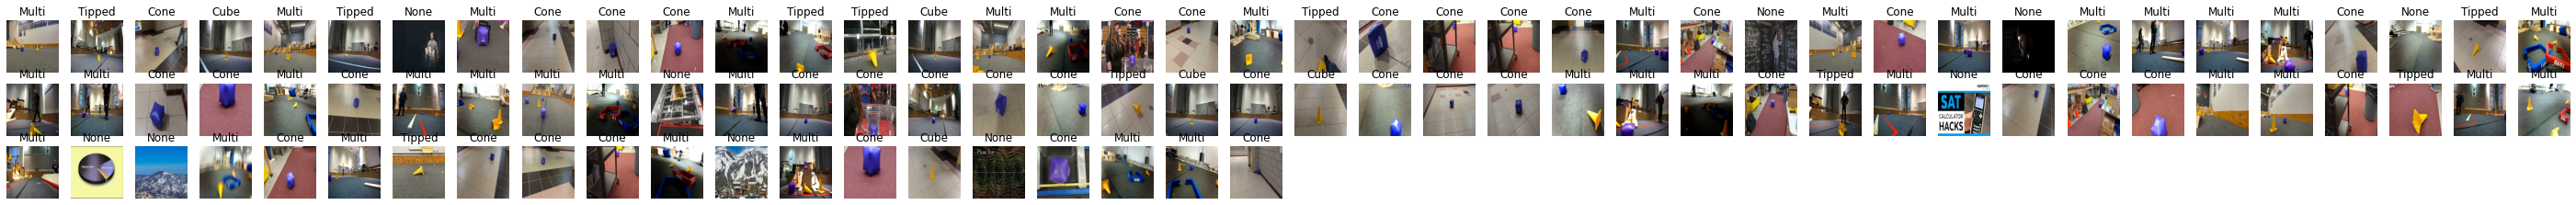

In [1]:
import tensorflow as tf

def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
    }

    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_image(example['image/encoded'], channels=3)
    label = example['image/object/class/label']
    return image, label

filenames = ['./data/FRC Charged Up Game Pieces.v7i.tfrecord/test/cubes-cones.tfrecord']  # Replace with your actual filenames
dataset = tf.data.TFRecordDataset(filenames)
prepared_dataset = dataset.map(parse_tfrecord_fn)

import numpy as np
import matplotlib.pyplot as plt

example_images = []
example_labels = []

for image, label_sparse in prepared_dataset.take(100):
    example_images.append(image.numpy())
    label_dense = tf.sparse.to_dense(label_sparse)
    label_values = label_dense.numpy()
    example_labels.append(label_values)

class_names = ["Cube", "Cone", "Tipped"]  # Replace with your actual class names

# Plot the extracted examples
num_images = len(example_images)
plt.figure(figsize=(50, 50))
for i in range(num_images):
    plt.subplot(40, 40, i + 1)
    plt.imshow(example_images[i])
    if len(example_labels[i]) > 1:
        plt.title('Multi')
    elif len(example_labels[i]) == 0:
        plt.title('None')
    else:
        plt.title(class_names[example_labels[i][0] - 1])
    plt.axis('off')
plt.show()



In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import psutil
from keras_cv import visualization
import tqdm

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
image_batch = inference_resizing([example_images[0]])

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using TensorFlow backend


In [3]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))


In [4]:
pretrained_model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

1/1 [==============================] - 42s 42s/step


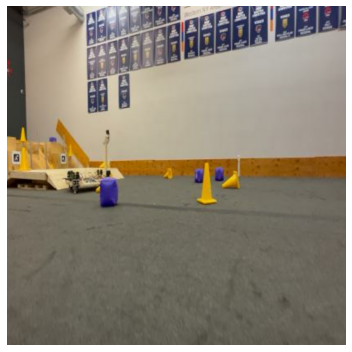

In [5]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In [6]:
import tensorflow as tf

# Define the function to parse TFRecord examples
def parse_tfrecord_fn(example):
    # Feature description
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
    }

    example = tf.io.parse_single_example(example, feature_description)
    return example

# Load and preprocess the TFRecord dataset
filenames = ['./data/FRC Charged Up Game Pieces.v7i.tfrecord/test/cubes-cones.tfrecord']
dataset = tf.data.TFRecordDataset(filenames)
prepared_dataset = dataset.map(parse_tfrecord_fn)

# Calculate the dataset size manually
train_size = 0
for _ in prepared_dataset:
    train_size += 1

# Split the dataset into training and validation sets
train_dataset = prepared_dataset.take(train_size)
val_dataset = prepared_dataset.skip(train_size)

# Define the function to normalize image features
def normalize_image_features(features):
    image = tf.image.decode_image(features['image/encoded'], channels=3)
    normalized_image = tf.cast(image, tf.float32) / 255.0
    return normalized_image, features['image/object/class/label']

train_dataset = train_dataset.map(normalize_image_features)
val_dataset = val_dataset.map(normalize_image_features)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None]), tf.int64))>

In [ ]:

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(3, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

# Train the model...
num_epochs = 10
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

# Evaluate the model...
loss, accuracy = model.evaluate(val_dataset)

# Print evaluation results
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)